# 1 Dependencies import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts import quickml
from scripts.utils import fill_infos

# pd.set_option("display.max_columns", None)
# pd.set_option("display.max_rows", None)

np.random.seed(294697)

***
# 2 Data import

For performance reasons, i choose to write a function that allow me to "chunk" the dataset and only take a percentage. I use a method for taking randomly the rows in each chunk, the result is that the output dataset have the same shape than if it was the original one.

In [2]:
original_dataset = quickml.read_csv(pd, np, "./datas/en.openfoodfacts.org.products.csv", 5, delimiter="\t")

/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,13,27,28,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,13,29,31,52) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,13,64) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (0,8,13,52,55,64) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
/opt/anaco

In [3]:
rows_nb, cols_nb = original_dataset.shape
original_dataset.shape

(95365, 186)

In [4]:
original_dataset.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
86295,00380652,http://world-en.openfoodfacts.org/product/0038...,kiliweb,1582652492,2020-02-25T17:41:32Z,1587336818,2020-04-19T22:53:38Z,Hot & spcy goujons,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
328,0000000200349,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1525780476,2018-05-08T11:54:36Z,1561463838,2019-06-25T11:57:18Z,Mini muffins fourrés caramel 8+4GRT,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16717,0011225124501,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489078023,2017-03-09T16:47:03Z,1609135345,2020-12-28T06:02:25Z,Hazelnut Non-Dairy Coffee Creamer,NaN,NaN,...,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46618,22314015020,http://world-en.openfoodfacts.org/product/0022...,kiliweb,1547133447,2019-01-10T15:17:27Z,1547133448,2019-01-10T15:17:28Z,Crême De Marrons De L'ardèche,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47547,23087000305,http://world-en.openfoodfacts.org/product/0023...,usda-ndb-import,1489135327,2017-03-10T08:42:07Z,1587627195,2020-04-23T07:33:15Z,Jalapeno Peanut Brittle,NaN,NaN,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data = original_dataset.copy()

***
# 3 Cleaning

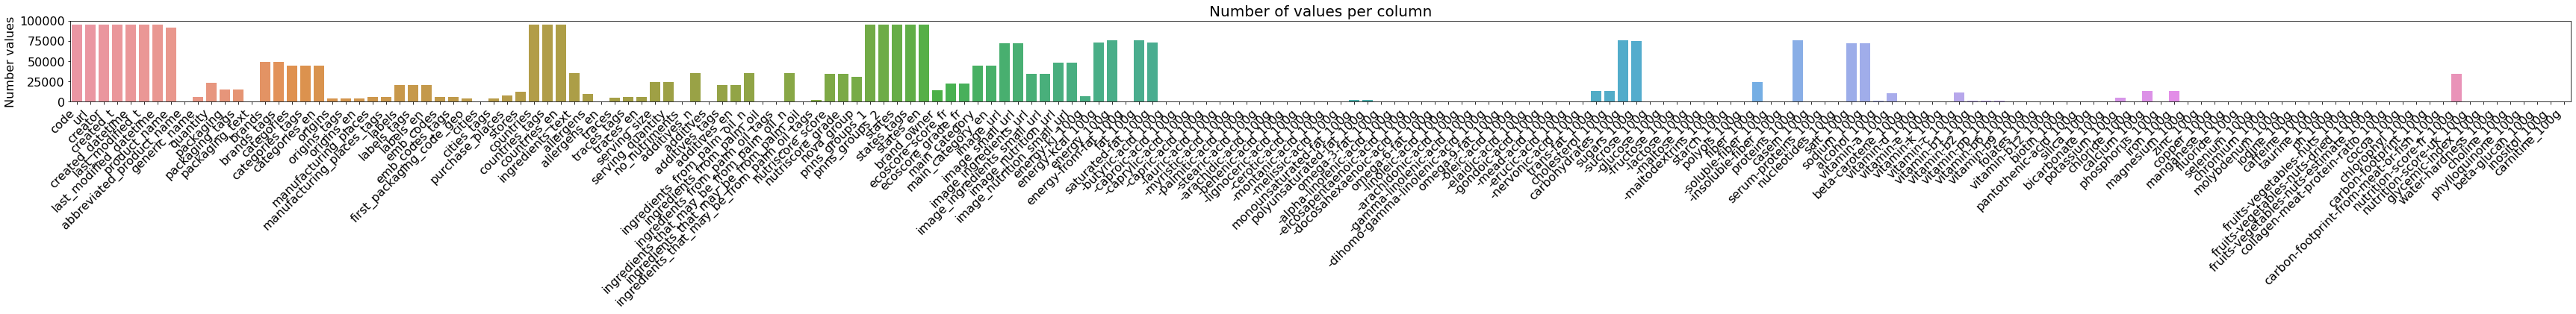

In [6]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=data.columns, y=data.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

### Shape comparison with original dataset

Original dataset  
![dataset_100_percent](images/global_overview_100p.png)

In [7]:
features = []

***
## 3.1 General informations group

### 3.1.1 Overview

In [378]:
general_infos_features = data.loc[:, "code":"quantity"].columns
general_infos_features

Index(['code', 'url', 'creator', 'created_t', 'created_datetime',
       'last_modified_t', 'last_modified_datetime', 'product_name',
       'abbreviated_product_name', 'generic_name', 'quantity'],
      dtype='object')

In [379]:
general_infos = data.loc[:, general_infos_features]

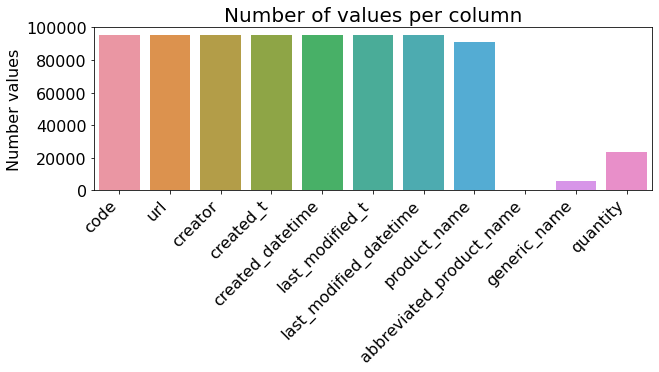

In [380]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos_features, y=data[general_infos_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [381]:
general_infos.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,quantity
86295,00380652,http://world-en.openfoodfacts.org/product/0038...,kiliweb,1582652492,2020-02-25T17:41:32Z,1587336818,2020-04-19T22:53:38Z,Hot & spcy goujons,NaN,NaN,NaN
328,0000000200349,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1525780476,2018-05-08T11:54:36Z,1561463838,2019-06-25T11:57:18Z,Mini muffins fourrés caramel 8+4GRT,NaN,NaN,NaN
16717,0011225124501,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489078023,2017-03-09T16:47:03Z,1609135345,2020-12-28T06:02:25Z,Hazelnut Non-Dairy Coffee Creamer,NaN,NaN,NaN
46618,22314015020,http://world-en.openfoodfacts.org/product/0022...,kiliweb,1547133447,2019-01-10T15:17:27Z,1547133448,2019-01-10T15:17:28Z,Crême De Marrons De L'ardèche,NaN,NaN,NaN
47547,23087000305,http://world-en.openfoodfacts.org/product/0023...,usda-ndb-import,1489135327,2017-03-10T08:42:07Z,1587627195,2020-04-23T07:33:15Z,Jalapeno Peanut Brittle,NaN,NaN,NaN


In [382]:
general_infos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   code                      95365 non-null  object
 1   url                       95365 non-null  object
 2   creator                   95365 non-null  object
 3   created_t                 95365 non-null  int64 
 4   created_datetime          95365 non-null  object
 5   last_modified_t           95365 non-null  int64 
 6   last_modified_datetime    95365 non-null  object
 7   product_name              91279 non-null  object
 8   abbreviated_product_name  313 non-null    object
 9   generic_name              5960 non-null   object
 10  quantity                  23544 non-null  object
dtypes: int64(2), object(9)
memory usage: 10.7+ MB


***
### 3.1.2 Usability

#### 3.1.2.1 Usability: Quantity

In [383]:
general_infos[general_infos.quantity.notna()].quantity.head(10)

90448                      3.2 kilos
98212                              7
70965                           311g
88400                        200 g e
90531              7.20 oz (204.1 g)
22851                          198 g
37390    Net WT 24 oz (1lb 8oz) 680g
52088                            473
52928                           90 g
48088                  85 g ( 3 oz )
Name: quantity, dtype: object

The feature "quantity" is highly non homogeneous and will be very difficult to use. We will not keep it.

In [384]:
general_infos.drop(columns=["quantity"], inplace=True)

***
### 3.1.3 Redundancy

#### 3.1.3.1 Redundancy: product_name, abbreviated_product_name, generic_name

In [385]:
general_infos[general_infos.generic_name.notna()].product_name.isna().sum()

7

In [ ]:
general_infos.loc[:, ["abbreviated_product_name", "generic_name", "product_name"]].iloc[:].head()

,abbreviated_product_name,generic_name,product_name
11205,NaN,NaN,Mild italian ground sausage
92166,NaN,NaN,I cant believe it’s not butter
64418,NaN,NaN,Watermelon chunks
8903,NaN,NaN,Sliced yellow cling peaches in water
50762,NaN,NaN,White fudge dipped snow covered chocolate chip...


We can see that 'abbreviated_product_name' contains too fews entries to be usefull.  
Regarding the 'generic_name', the fill percentage is not very high, but worst, each time 'generic_name' is filled, so is 'product_name'.

In [387]:
general_infos.drop(columns=["abbreviated_product_name", "generic_name"], inplace=True)

***
### 3.1.4 Conclusion

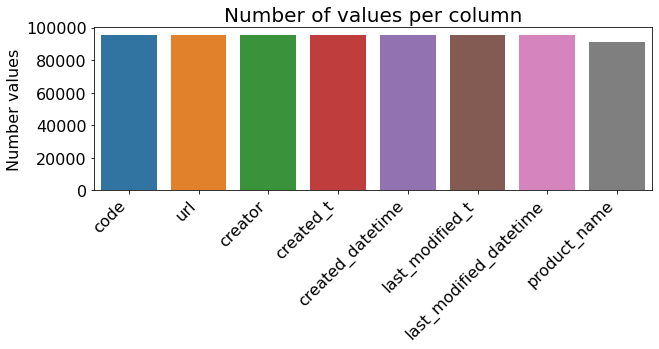

In [388]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos.columns, y=general_infos.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

#### 3.1.4.1 Original

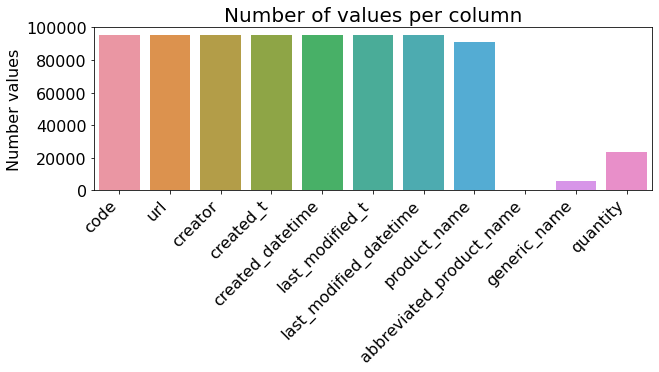

In [389]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=general_infos_features, y=data[general_infos_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
## 3.2 Tags group

### 3.2.1 Overview

In [390]:
tags_features = data.loc[:, "packaging":"countries_en"].columns
tags_features

Index(['packaging', 'packaging_tags', 'packaging_text', 'brands',
       'brands_tags', 'categories', 'categories_tags', 'categories_en',
       'origins', 'origins_tags', 'origins_en', 'manufacturing_places',
       'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en',
       'emb_codes', 'emb_codes_tags', 'first_packaging_code_geo', 'cities',
       'cities_tags', 'purchase_places', 'stores', 'countries',
       'countries_tags', 'countries_en'],
      dtype='object')

In [391]:
tags = data.loc[:, tags_features]

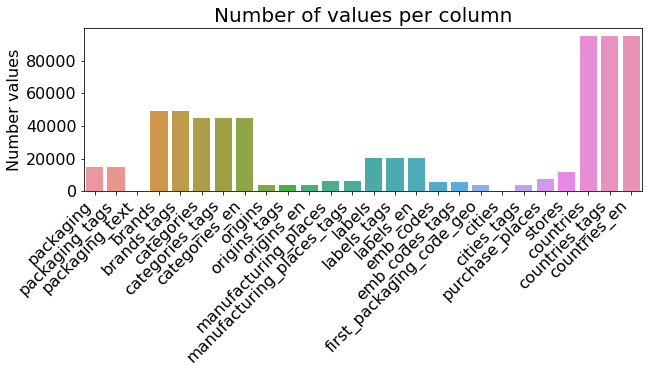

In [392]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=tags.columns, y=tags.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [393]:
tags.head()

,packaging,packaging_tags,packaging_text,brands,brands_tags,categories,categories_tags,categories_en,origins,origins_tags,...,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags,countries_en
86295,NaN,NaN,NaN,Sainsburys,sainsburys,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:gb,en:united-kingdom,United Kingdom
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,France,en:france,France
16717,NaN,NaN,NaN,Kingston Marketing Co,kingston-marketing-co,"Milk substitute, Creamer","en:milk-substitute,en:creamer","Milk substitute,Creamer",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States
46618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en:france,en:france,France
47547,NaN,NaN,NaN,Mrs. Annies,mrs-annies,"Snacks, Sweet snacks, Confectioneries","en:snacks,en:sweet-snacks,en:confectioneries","Snacks,Sweet snacks,Confectioneries",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,en:united-states,United States


In [394]:
tags.iloc[:, :13].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   packaging                  14730 non-null  object
 1   packaging_tags             14729 non-null  object
 2   packaging_text             278 non-null    object
 3   brands                     49044 non-null  object
 4   brands_tags                49041 non-null  object
 5   categories                 44832 non-null  object
 6   categories_tags            44831 non-null  object
 7   categories_en              44831 non-null  object
 8   origins                    3983 non-null   object
 9   origins_tags               3979 non-null   object
 10  origins_en                 3979 non-null   object
 11  manufacturing_places       5976 non-null   object
 12  manufacturing_places_tags  5976 non-null   object
dtypes: object(13)
memory usage: 12.2+ MB


In [395]:
tags.iloc[:, 13:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   labels                    20236 non-null  object 
 1   labels_tags               20236 non-null  object 
 2   labels_en                 20236 non-null  object 
 3   emb_codes                 5893 non-null   object 
 4   emb_codes_tags            5892 non-null   object 
 5   first_packaging_code_geo  3593 non-null   object 
 6   cities                    0 non-null      float64
 7   cities_tags               3854 non-null   object 
 8   purchase_places           7652 non-null   object 
 9   stores                    11860 non-null  object 
 10  countries                 95109 non-null  object 
 11  countries_tags            95109 non-null  object 
 12  countries_en              95109 non-null  object 
dtypes: float64(1), object(12)
memory usage: 12.2+ MB


***
### 3.2.2 Usability

#### 3.2.2.1 Usability: packaging_text

In [396]:
tags.packaging_text.notna().sum()

278

In [397]:
tags.drop(columns=["packaging_text"], inplace=True)

***
#### 3.2.2.2 Usability: cities

In [398]:
tags.cities.notna().sum()

0

In [399]:
tags.drop(columns=["cities"], inplace=True)

***
### 3.2.3 Redundancy

#### 3.2.3.1 Redundancy: packaging, packaging_tags

In [400]:
tags.loc[:, ["packaging", "packaging_tags"]].loc[tags.packaging.notna() & tags.packaging_tags.notna()].iloc[:20]

,packaging,packaging_tags
88400,"carton,boîte,plastique","carton,boite,plastique"
90531,"Plastic,Pouch","plastic,pouch"
22851,"PAPEL,BOLSA","papel,bolsa"
59614,en:paper-box,en-paper-box
37390,"Jar,Glass","jar,glass"
52928,"frais,plastique","frais,plastique"
48088,sachet plastique,sachet-plastique
49499,Dose,dose
54665,"Box,Plastic bags,microwavable bags","box,plastic-bags,microwavable-bags"
26986,"frais,plastique,décongelé","frais,plastique,decongele"


In [401]:
tags[tags.packaging_tags.notna()].loc[:,["packaging"]].isna().sum()

packaging    0
dtype: int64

We can see that each time one of the features "packaging" or "packaging_tags" is filled, the other is also filled.
We will keep the feature "packaging" because it transport more information, plus, it's easier to get rid of the "en:", "fr:" than "en-", because in "packaging_tags" each separator is a "-" and not in "packaging".

In [402]:
tags.drop(columns=["packaging_tags"], inplace=True)

***
#### 3.2.3.2 Redundancy: brands, brands_tags

In [403]:
tags.iloc[:20].loc[:, ["brands", "brands_tags"]]

,brands,brands_tags
86295,Sainsburys,sainsburys
328,NaN,NaN
16717,Kingston Marketing Co,kingston-marketing-co
46618,NaN,NaN
47547,Mrs. Annies,mrs-annies
48409,Nature Raised Farms,nature-raised-farms
67078,NaN,NaN
70100,Sun Of Italy,sun-of-italy
40013,Signature Select,signature-select
82134,Food Club,food-club


In [404]:
tags[tags.brands_tags.notna()].loc[:,["brands"]].isna().sum()

brands    0
dtype: int64

The features "brands" and "brands_tags" are almost equally filled. We will keep "brands" because this feature carry most information (spaces, capital letters...)

In [405]:
tags.drop(columns=["brands_tags"], inplace=True)

***
#### 3.2.3.3 Redundancy: categories, categories_tags, categories_en

In [406]:
tags.loc[:, ["categories", "categories_tags", "categories_en"]].iloc[:20]

,categories,categories_tags,categories_en
86295,NaN,NaN,NaN
328,NaN,NaN,NaN
16717,"Milk substitute, Creamer","en:milk-substitute,en:creamer","Milk substitute,Creamer"
46618,NaN,NaN,NaN
47547,"Snacks, Sweet snacks, Confectioneries","en:snacks,en:sweet-snacks,en:confectioneries","Snacks,Sweet snacks,Confectioneries"
48409,Frozen foods,en:frozen-foods,Frozen foods
67078,NaN,NaN,NaN
70100,Salted snacks,en:salted-snacks,Salted-snacks
40013,"Desserts, Frozen foods, Frozen desserts, Ice c...","en:desserts,en:frozen-foods,en:frozen-desserts...","Desserts,Frozen foods,Frozen desserts,Ice crea..."
82134,"Biscuits and cakes, Cakes, Cooking helpers, De...","en:biscuits-and-cakes,en:cooking-helpers,en:ca...","Biscuits and cakes,Cooking helpers,Cakes,Desse..."


In [407]:
tags[tags.categories.notna()].loc[:,["categories_en"]].isna().sum()

categories_en    1
dtype: int64

In [408]:
tags[tags.categories_tags.notna()].loc[:,["categories_en"]].isna().sum()

categories_en    0
dtype: int64

We will keep "categories_en".

In [409]:
tags.drop(columns=["categories", "categories_tags"], inplace=True)

***
#### 3.2.3.4 Redundancy: origins, origins_tags, origins_en

In [410]:
tags.loc[:, ["origins", "origins_tags", "origins_en"]].loc[tags.origins.notna() & tags.origins_tags.notna() & tags.origins_en.notna()].iloc[:20]

,origins,origins_tags,origins_en
22851,ESTADOS UNIDOS,en:estados-unidos,Estados-unidos
52928,Royaume-Uni,en:united-kingdom,United Kingdom
14446,Estero,it:estero,it:estero
98816,Peru,en:peru,Peru
92278,"en:United Kingdom,New Zealand","en:new-zealand,en:united-kingdom","New Zealand,United Kingdom"
54635,United States,en:united-states,United States
18751,Pakistan,en:pakistan,Pakistan
29438,Thailand,en:thailand,Thailand
31041,USA,en:united-states,United States
97423,United States,en:united-states,United States


In [411]:
tags[tags.origins_tags.notna()].loc[:,["origins"]].isna().sum()

origins    0
dtype: int64

In [412]:
tags[tags.origins_en.notna()].loc[:,["origins"]].isna().sum()

origins    0
dtype: int64

We will keep the feature "origins"

In [413]:
tags.drop(columns=["origins_tags", "origins_en"], inplace=True)

***
#### 3.2.3.5 Redundancy: manufacturing_places, manufacturing_places_tags

In [414]:
tags.loc[:, ["manufacturing_places", "manufacturing_places_tags"]].loc[tags.manufacturing_places.notna() & tags.manufacturing_places_tags.notna()].iloc[:20]

,manufacturing_places,manufacturing_places_tags
88400,"Écosse,Royaume-Uni","ecosse,royaume-uni"
22851,ESTADOS UNIDOS,estados-unidos
52928,Royaume-Uni,royaume-uni
14446,Italia,italia
8871,United States,united-states
98816,peru,peru
18231,Royaume-Uni,royaume-uni
49508,Italien,italien
54048,"Royaume-Uni,Écosse","royaume-uni,ecosse"
4981,"Latina,italia","latina,italia"


We will keep the feature "manufacturing_places"

In [415]:
tags.drop(columns=["manufacturing_places_tags"], inplace=True)

***
#### 3.2.3.6 labels, labels_tags, labels_en

In [416]:
tags.loc[:, ["labels", "labels_tags", "labels_en"]].loc[tags.labels.notna() & tags.labels_en.notna() & tags.labels_en.notna()].iloc[:20]

,labels,labels_tags,labels_en
210,Organic,en:organic,Organic
63947,Organic,en:organic,Organic
90448,en:usda-organic,"en:organic,en:usda-organic","Organic,USDA Organic"
22510,Organic,en:organic,Organic
30267,Punto Verde,en:green-dot,Green Dot
70965,en:gluten-free,en:gluten-free,Gluten-free
21380,Organic,en:organic,Organic
88400,"Kosher, Orthodox Union Kosher, Kascher, Point ...","en:kosher,en:orthodox-union-kosher,en:kascher,...","Kosher,Orthodox Union Kosher,Kascher,Point-ver..."
90531,"Gluten-free, Without-gelatin","en:no-gluten,en:no-gelatin","No gluten,No gelatin"
9456,Verified,en:verified,Verified


We will keep "labels_en"

In [417]:
tags.drop(columns=["labels", "labels_tags"], inplace=True)

***
#### 3.2.3.7 emb_codes, emb_codes_tags

In [418]:
tags.loc[:, ["emb_codes", "emb_codes_tags"]].loc[tags.emb_codes.notna() & tags.emb_codes_tags.notna()].iloc[:20]

,emb_codes,emb_codes_tags
92278,UK JF062 EC,uk-jf062-ec
18751,CML/PZ-089/2019,cml-pz-089-2019
36643,FSC-C012938,fsc-c012938
88108,011915.DUPR3,011915-dupr3
92861,NSW 2477,nsw-2477
750,"ES 26.01868/TO EC, FABRICANTE Y ENVASADOR:, BO...","es-26-01868-to-ec,fabricante-y-envasador,bolto..."
37,FR 72.264.002 EC,fr-72-264-002-ec
46380,UK 7195 EC,uk-7195-ec
83003,FR 14.162.001 EC,fr-14-162-001-ec
63563,30100100683,30100100683


We will keep "emb_codes".

In [419]:
tags.drop(columns=["emb_codes_tags"], inplace=True)

***
#### 3.2.3.8 countries, countries_tags, countries_en

In [420]:
tags.iloc[:20,:].loc[:,["countries", "countries_tags", "countries_en"]]

,countries,countries_tags,countries_en
86295,en:gb,en:united-kingdom,United Kingdom
328,France,en:france,France
16717,United States,en:united-states,United States
46618,en:france,en:france,France
47547,United States,en:united-states,United States
48409,United States,en:united-states,United States
67078,en:us,en:united-states,United States
70100,United States,en:united-states,United States
40013,United States,en:united-states,United States
82134,United States,en:united-states,United States


In [421]:
fill_infos(tags, "countries_en")

countries_en total rows:  95109
countries_en filled count:  94853
countries_en filled percentage:  3.7151953125


In [422]:
tags.drop(columns=["countries", "countries_tags"], inplace=True)

***
### 3.2.4 Conclusion

In [423]:
tags.describe()

,packaging,brands,categories_en,origins,manufacturing_places,labels_en,emb_codes,first_packaging_code_geo,cities_tags,purchase_places,stores,countries_en
count,14730,49044,44831,3983,5976,20236,5893,3593,3854,7652,11860,95109
unique,5161,21328,9054,1140,2418,5199,3879,1198,1617,1355,1675,703
top,Kunststoff,Carrefour,Snacks,France,France,Organic,FSC-C014047,"47.833333,-0.333333",sable-sur-sarthe-sarthe-france,France,Carrefour,France
freq,337,797,1609,997,1204,2363,78,57,48,2089,1169,37789


In [424]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   packaging                 14730 non-null  object
 1   brands                    49044 non-null  object
 2   categories_en             44831 non-null  object
 3   origins                   3983 non-null   object
 4   manufacturing_places      5976 non-null   object
 5   labels_en                 20236 non-null  object
 6   emb_codes                 5893 non-null   object
 7   first_packaging_code_geo  3593 non-null   object
 8   cities_tags               3854 non-null   object
 9   purchase_places           7652 non-null   object
 10  stores                    11860 non-null  object
 11  countries_en              95109 non-null  object
dtypes: object(12)
memory usage: 11.5+ MB


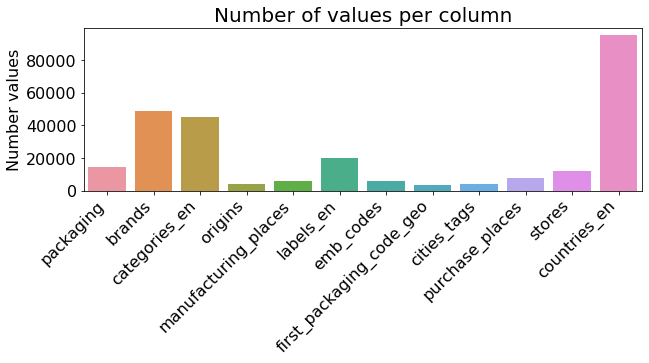

In [425]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=tags.columns, y=tags.apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

#### 3.2.4.1 Original

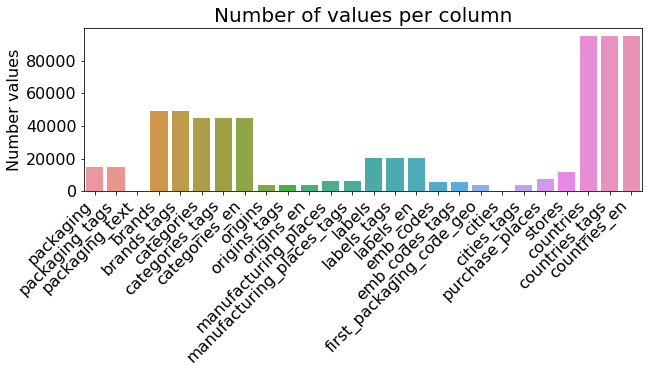

In [426]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=data[tags_features].columns, y=data[tags_features].apply(lambda row: row.count(), axis=0))

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
## 3.3 Ingredients group

### 3.3.1 Overview

In [427]:
ingredients_features = data.loc[:, "ingredients_text":"traces_tags"].columns
ingredients_features

Index(['ingredients_text', 'allergens', 'allergens_en', 'traces',
       'traces_tags'],
      dtype='object')

In [428]:
ingredients = data.loc[:, ingredients_features]

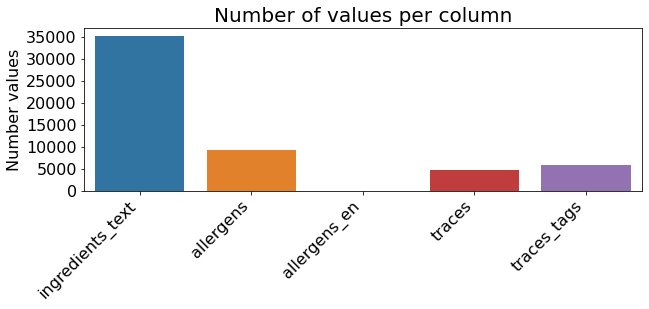

In [429]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients_features, y=ingredients.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [430]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ingredients_text  35207 non-null  object 
 1   allergens         9226 non-null   object 
 2   allergens_en      0 non-null      float64
 3   traces            4768 non-null   object 
 4   traces_tags       5918 non-null   object 
dtypes: float64(1), object(4)
memory usage: 6.4+ MB


In [431]:
ingredients.head()

,ingredients_text,allergens,allergens_en,traces,traces_tags
86295,NaN,NaN,NaN,NaN,NaN
328,NaN,NaN,NaN,NaN,NaN
16717,"water, sugar, soybean and/or palm oil, and les...",NaN,NaN,NaN,NaN
46618,NaN,NaN,NaN,NaN,NaN
47547,"Peanuts, granulated sugar, light corn syrup (w...",NaN,NaN,NaN,NaN


***
### 3.3.2 Usability

#### 3.3.2.1 Usability: allergens_en

"allergens_en" is completely empty.

In [432]:
ingredients.drop(columns=["allergens_en"], inplace=True)

***
### 3.3.3 Redundancy

#### 3.3.3.1 Redundancy: traces, traces_tags

In [433]:
ingredients.loc[:, ["traces", "traces_tags"]].loc[ingredients.traces.notna() & ingredients.traces_tags.notna()].iloc[:20]

,traces,traces_tags
88400,en:nuts,en:nuts
54080,en:eggs,en:eggs
63198,en:soybeans,en:soybeans
18231,en:nuts,en:nuts
88690,"en:gluten,en:milk","en:gluten,en:milk,en:soybeans"
54048,"en:nuts,en:peanuts","en:nuts,en:peanuts"
64098,en:milk,en:milk
291,"en:eggs,en:gluten,en:milk,en:nuts,en:soybeans,...","en:eggs,en:gluten,en:milk,en:nuts,en:soybeans,..."
28664,"en:nuts,en:soybeans,es:COCO Y LECHE","en:nuts,en:soybeans,es:coco-y-leche"
89879,"en:milk,en:nuts,en:soybeans","en:milk,en:nuts,en:soybeans"


There is, at first sight, no better feature. We will keep "traces"

In [434]:
ingredients.drop(columns=["traces_tags"], inplace=True)

***
### 3.3.4 Conclusion

In [435]:
ingredients.describe()

,ingredients_text,allergens,traces
count,35207,9226,4768
unique,33679,691,1215
top,"Carbonated water, natural flavor.",en:milk,en:nuts
freq,29,1985,427


In [436]:
ingredients.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   ingredients_text  35207 non-null  object
 1   allergens         9226 non-null   object
 2   traces            4768 non-null   object
dtypes: object(3)
memory usage: 4.9+ MB


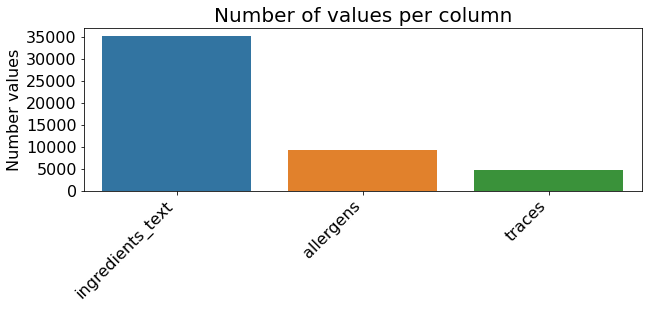

In [437]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients.columns, y=ingredients.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

#### 3.3.4.1 Original

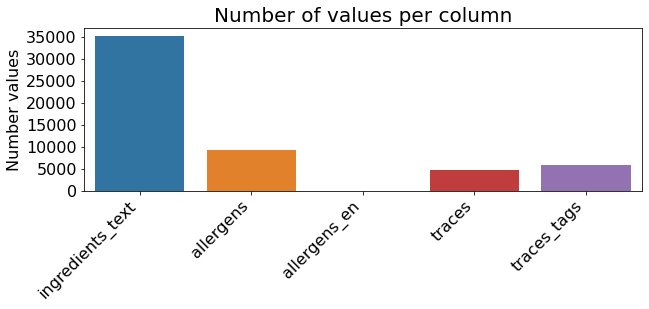

In [438]:
plt.figure(figsize=(10,3))

barplot = sns.barplot(x=ingredients_features, y=data[ingredients_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
## 3.4 Misc datas group

#### 3.4.1 Overview

In [439]:
misc_features = data.loc[:,"serving_size":"image_nutrition_small_url"].columns
misc_features

Index(['serving_size', 'serving_quantity', 'no_nutriments', 'additives_n',
       'additives', 'additives_tags', 'additives_en',
       'ingredients_from_palm_oil_n', 'ingredients_from_palm_oil',
       'ingredients_from_palm_oil_tags',
       'ingredients_that_may_be_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil',
       'ingredients_that_may_be_from_palm_oil_tags', 'nutriscore_score',
       'nutriscore_grade', 'nova_group', 'pnns_groups_1', 'pnns_groups_2',
       'states', 'states_tags', 'states_en', 'brand_owner',
       'ecoscore_score_fr', 'ecoscore_grade_fr', 'main_category',
       'main_category_en', 'image_url', 'image_small_url',
       'image_ingredients_url', 'image_ingredients_small_url',
       'image_nutrition_url', 'image_nutrition_small_url'],
      dtype='object')

In [440]:
misc = data.loc[:, misc_features]

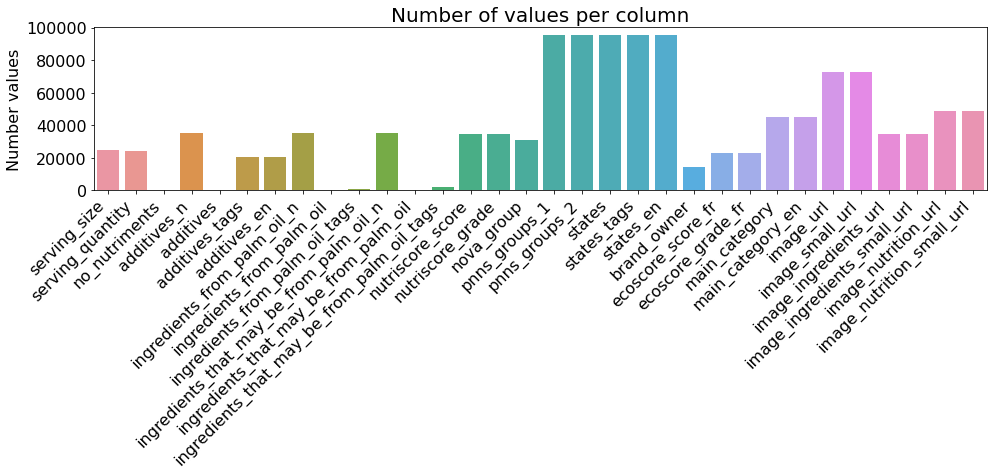

In [441]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc_features, y=data[misc_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [442]:
misc.iloc[:, :16].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 16 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   serving_size                                24517 non-null  object 
 1   serving_quantity                            24271 non-null  float64
 2   no_nutriments                               0 non-null      float64
 3   additives_n                                 35208 non-null  float64
 4   additives                                   0 non-null      float64
 5   additives_tags                              20201 non-null  object 
 6   additives_en                                20201 non-null  object 
 7   ingredients_from_palm_oil_n                 35208 non-null  float64
 8   ingredients_from_palm_oil                   0 non-null      float64
 9   ingredients_from_palm_oil_tags              693 non-null    object 
 10  ingr

In [443]:
misc.iloc[:, 16:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pnns_groups_1                95353 non-null  object 
 1   pnns_groups_2                95353 non-null  object 
 2   states                       95365 non-null  object 
 3   states_tags                  95365 non-null  object 
 4   states_en                    95365 non-null  object 
 5   brand_owner                  14467 non-null  object 
 6   ecoscore_score_fr            22854 non-null  float64
 7   ecoscore_grade_fr            22854 non-null  object 
 8   main_category                44831 non-null  object 
 9   main_category_en             44831 non-null  object 
 10  image_url                    72523 non-null  object 
 11  image_small_url              72523 non-null  object 
 12  image_ingredients_url        34698 non-null  object 
 13  image_ingr

In [444]:
misc.head(1)

,serving_size,serving_quantity,no_nutriments,additives_n,additives,additives_tags,additives_en,ingredients_from_palm_oil_n,ingredients_from_palm_oil,ingredients_from_palm_oil_tags,...,ecoscore_score_fr,ecoscore_grade_fr,main_category,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url
86295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...


***
### 3.4.2 Usability

These features are competely empty and then will be no needed:
- no_nutriments
- additives
- ingredients_from_palm_oil
- ingredients_that_may_be_from_palm_oil

These features are almost empty, we will get rid of them too:
- ingredients_from_palm_oil_tags
- ingredients_that_may_be_from_palm_oil_tags

In [445]:
misc.drop(columns=["no_nutriments", "additives", "ingredients_from_palm_oil", "ingredients_that_may_be_from_palm_oil", "ingredients_from_palm_oil_tags", "ingredients_that_may_be_from_palm_oil_tags"], inplace=True)

***
### 3.4.3 Redundancy

#### 3.4.3.1 Redundancy: serving_siez, serving_quantity

In [446]:
misc.loc[:, ["serving_size", "serving_quantity"]].iloc[:20]

,serving_size,serving_quantity
86295,NaN,NaN
328,NaN,NaN
16717,1 Tbsp (15 ml),15.0
46618,NaN,NaN
47547,2 ONZ (57 g),57.0
48409,3 ONZ (84 g),84.0
67078,NaN,NaN
70100,4 PEPPERS (31 g),31.0
40013,0.666 cup (90 g),90.0
82134,0.333 cup (39 g),39.0


It appears that the feature "serving_size" is non homogeneous in term of units. The feature "serving_quantity" on the other hand, seems to be only in the same unit (g).
We will keep "serving_quantity"

In [447]:
misc.drop(columns=["serving_size"], inplace=True)

***
#### 3.4.3.2 Redundancy: additives_tags, additives_en

In [448]:
misc.loc[:, ["additives_n", "additives_tags", "additives_en"]].iloc[:10]

,additives_n,additives_tags,additives_en
86295,NaN,NaN,NaN
328,NaN,NaN,NaN
16717,6.0,"en:e340,en:e340ii,en:e407,en:e435,en:e466,en:e...","E340 - Potassium phosphates,E340ii - Dipotassi..."
46618,NaN,NaN,NaN
47547,6.0,"en:e160a,en:e160ai,en:e211,en:e322,en:e322i,en...","E160a - Carotene,E160ai - Beta-carotene,E211 -..."
48409,1.0,en:e330,E330 - Citric acid
67078,NaN,NaN,NaN
70100,3.0,"en:e102,en:e222,en:e330","E102 - Tartrazine,E222 - Sodium bisulphite,E33..."
40013,10.0,"en:e150c,en:e202,en:e322,en:e322i,en:e407,en:e...","E150c - Ammonia caramel,E202 - Potassium sorba..."
82134,4.0,"en:e341,en:e341i,en:e415,en:e500,en:e500ii,en:...","E341 - Calcium phosphates,E341i - Monocalcium ..."


The feature "additives_en" contains more informations and seems to be easier to parse compare to "additives_tags". Regarding "additives_n" it's the number of additives, there is no direct redundancy for that feature, we can keep it.
We will keep "additives_en" and "additives_n".

In [449]:
misc.drop(columns=["additives_tags"], inplace=True)

***
#### 3.4.3.3 Redundancy: nutriscore_score, nutriscore_grade

In [450]:
misc.loc[:, ["nutriscore_score", "nutriscore_grade"]].loc[misc.nutriscore_score.notna() & misc.nutriscore_grade.notna()].iloc[:20]

,nutriscore_score,nutriscore_grade
16717,10.0,c
47547,18.0,d
48409,5.0,c
70100,5.0,c
40013,17.0,d
43521,12.0,d
72905,1.0,b
14289,11.0,d
74750,4.0,c
63947,-1.0,a


We will keep both fields as one is quantitative and other is qualitative.

***
#### 3.4.3.4 Redundancy: pnns_groups_1, pnns_groups_2

In [451]:
misc.loc[:, ["pnns_groups_1", "pnns_groups_2"]].loc[misc.pnns_groups_1.notna()].iloc[:20]

,pnns_groups_1,pnns_groups_2
86295,unknown,unknown
328,unknown,unknown
16717,Beverages,Plant-based milk substitutes
46618,unknown,unknown
47547,Sugary snacks,Sweets
48409,unknown,unknown
67078,unknown,unknown
70100,unknown,unknown
40013,Milk and dairy products,Ice cream
82134,Sugary snacks,Biscuits and cakes


Both features don't contains same value, we will keep them.

***
#### 3.4.3.5 Redundancy: states, states_tags, states_en

In [452]:
misc.loc[:, ["states", "states_tags", "states_en"]].iloc[:10]

,states,states_tags,states_en
86295,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
328,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
16717,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
46618,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
47547,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
48409,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
67078,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
70100,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
40013,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
82134,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."


Seems to be all useless. Let's see how many rows doesn't contains 'to-be-completed' or 'To be completed' in those features.

In [453]:
misc.loc[~misc.states.str.contains("to-be-completed")].states.count()

747

In [454]:
misc.loc[~misc.states_tags.str.contains("to-be-completed")].states_tags.count()

747

In [455]:
misc.loc[~misc.states_en.str.contains("To be completed")].states_en.count()

3908

These features contains no usefull informations, we will get rid of them.

In [456]:
misc.drop(columns=["states", "states_tags", "states_en"], inplace=True)

***
#### 3.4.3.6 Redundancy: ecoscore_score_fr, ecoscore_grade_fr

In [457]:
misc.loc[:, ["ecoscore_score_fr", "ecoscore_grade_fr"]].loc[misc.ecoscore_score_fr.notna() & misc.ecoscore_grade_fr.notna()].iloc[:20]

,ecoscore_score_fr,ecoscore_grade_fr
40013,60.0,b
43521,38.0,d
42296,59.0,c
93738,80.0,b
9521,34.0,d
42124,57.0,c
28964,34.0,d
54128,77.0,b
30267,34.0,d
70965,4.0,e


As the nutriscore, both ecoscore are usefull, we will keep both.

***
#### 3.4.3.7 Redundancy: main_category, main_category_en

In [458]:
misc.loc[:, ["main_category", "main_category_en"]].iloc[:20]

,main_category,main_category_en
86295,NaN,NaN
328,NaN,NaN
16717,en:creamer,Creamer
46618,NaN,NaN
47547,en:confectioneries,Confectioneries
48409,en:frozen-foods,Frozen foods
67078,NaN,NaN
70100,en:salted-snacks,Salted-snacks
40013,en:ice-creams,Ice creams
82134,en:cake-mixes,Cake mixes


We will keep "main_category_en"

In [459]:
misc.drop(columns=["main_category"], inplace=True)

***
### 3.4.4 Conclusion

In [460]:
misc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 20 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   serving_quantity                         24271 non-null  float64
 1   additives_n                              35208 non-null  float64
 2   additives_en                             20201 non-null  object 
 3   ingredients_from_palm_oil_n              35208 non-null  float64
 4   ingredients_that_may_be_from_palm_oil_n  35208 non-null  float64
 5   nutriscore_score                         34849 non-null  float64
 6   nutriscore_grade                         34849 non-null  object 
 7   nova_group                               30742 non-null  float64
 8   pnns_groups_1                            95353 non-null  object 
 9   pnns_groups_2                            95353 non-null  object 
 10  brand_owner                             

In [461]:
misc.describe()

,serving_quantity,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nova_group,ecoscore_score_fr
count,24271.000000,35208.000000,35208.000000,35208.000000,34849.000000,30742.000000,22854.000000
mean,135.732589,2.011872,0.019853,0.069359,9.012683,3.428046,43.839503
std,6420.375211,2.880809,0.140715,0.302075,8.843759,0.966340,25.832415
min,0.000000,0.000000,0.000000,0.000000,-14.000000,1.000000,-19.000000
25%,28.000000,0.000000,0.000000,0.000000,1.000000,3.000000,27.000000
50%,53.000000,1.000000,0.000000,0.000000,10.000000,4.000000,38.000000
75%,115.000000,3.000000,0.000000,0.000000,16.000000,4.000000,64.000000
max,1000000.000000,32.000000,2.000000,5.000000,39.000000,4.000000,124.000000


In [462]:
misc.loc[:, :"main_category_en"].describe(include=[object])

,additives_en,nutriscore_grade,pnns_groups_1,pnns_groups_2,brand_owner,ecoscore_grade_fr,main_category_en
count,20201,34849,95353,95353,14467,22854,44831
unique,9325,5,11,40,4633,5,5826
top,E330 - Citric acid,d,unknown,unknown,"Wal-Mart Stores, Inc.",d,Snacks
freq,1289,10725,58930,58930,248,7768,1610


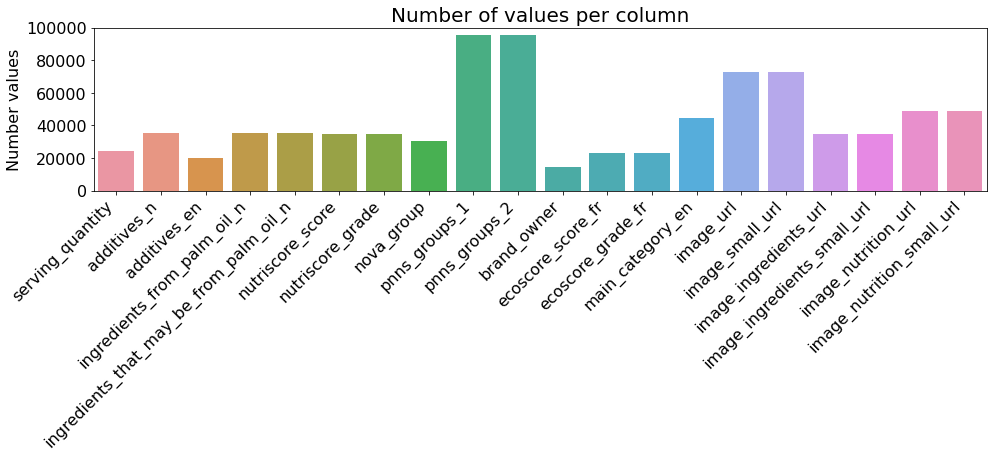

In [463]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc.columns, y=misc.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

#### 3.4.4.1 Original

In [464]:
plt.figure(figsize=(16,3))

barplot = sns.barplot(x=misc_features, y=data[misc_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
## 3.5 Nutrition facts group

### 3.5.1 Overview

In [ ]:
nutr_features = data.loc[:, "energy-kj_100g":"carnitine_100g"].columns
nutr_features

Index(['energy-kj_100g', 'energy-kcal_100g', 'energy_100g',
       'energy-from-fat_100g', 'fat_100g', 'saturated-fat_100g',
       '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g',
       '-capric-acid_100g',
       ...
       'carbon-footprint-from-meat-or-fish_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
       'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
       'inositol_100g', 'carnitine_100g'],
      dtype='object', length=111)

In [ ]:
nutr = data.loc[:, nutr_features]

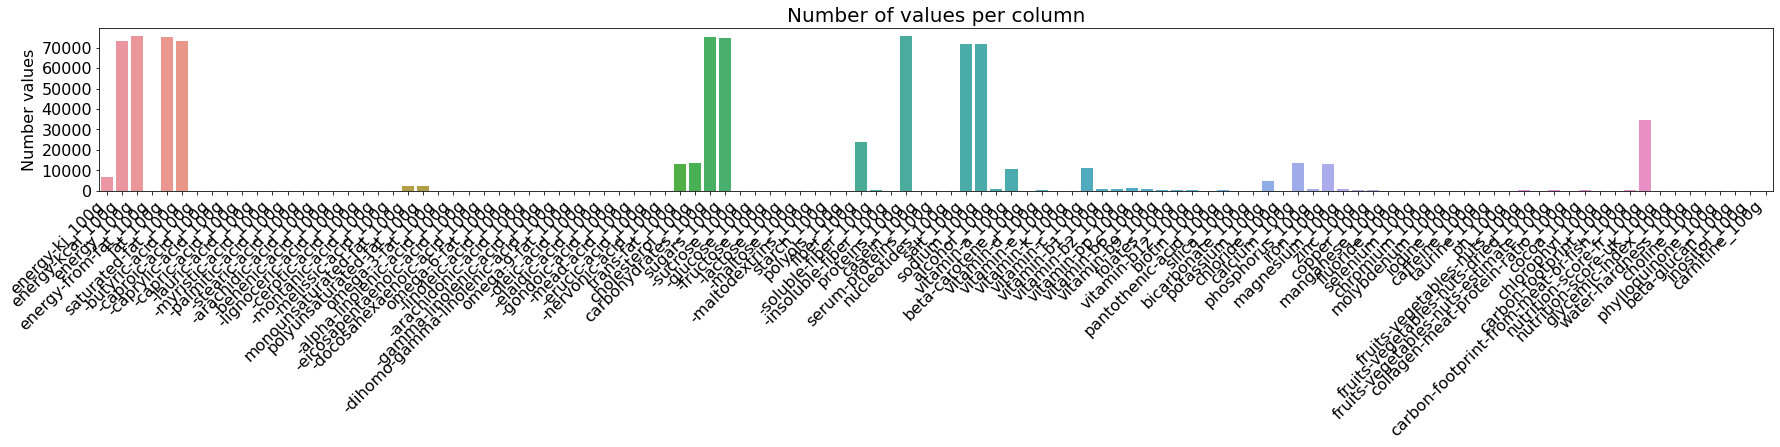

In [ ]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr_features, y=nutr.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

In [ ]:
nutr.iloc[:, :10].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   energy-kj_100g        6786 non-null   float64
 1   energy-kcal_100g      73310 non-null  float64
 2   energy_100g           75868 non-null  float64
 3   energy-from-fat_100g  65 non-null     float64
 4   fat_100g              75422 non-null  float64
 5   saturated-fat_100g    73224 non-null  float64
 6   -butyric-acid_100g    2 non-null      float64
 7   -caproic-acid_100g    0 non-null      float64
 8   -caprylic-acid_100g   0 non-null      float64
 9   -capric-acid_100g     0 non-null      float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 10:20].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   -lauric-acid_100g      2 non-null      float64
 1   -myristic-acid_100g    1 non-null      float64
 2   -palmitic-acid_100g    1 non-null      float64
 3   -stearic-acid_100g     0 non-null      float64
 4   -arachidic-acid_100g   6 non-null      float64
 5   -behenic-acid_100g     3 non-null      float64
 6   -lignoceric-acid_100g  3 non-null      float64
 7   -cerotic-acid_100g     1 non-null      float64
 8   -montanic-acid_100g    1 non-null      float64
 9   -melissic-acid_100g    3 non-null      float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 20:30].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   monounsaturated-fat_100g     2436 non-null   float64
 1   polyunsaturated-fat_100g     2441 non-null   float64
 2   omega-3-fat_100g             105 non-null    float64
 3   -alpha-linolenic-acid_100g   38 non-null     float64
 4   -eicosapentaenoic-acid_100g  7 non-null      float64
 5   -docosahexaenoic-acid_100g   14 non-null     float64
 6   omega-6-fat_100g             20 non-null     float64
 7   -linoleic-acid_100g          25 non-null     float64
 8   -arachidonic-acid_100g       7 non-null      float64
 9   -gamma-linolenic-acid_100g   0 non-null      float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 30:40].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   -dihomo-gamma-linolenic-acid_100g  1 non-null      float64
 1   omega-9-fat_100g                   4 non-null      float64
 2   -oleic-acid_100g                   4 non-null      float64
 3   -elaidic-acid_100g                 0 non-null      float64
 4   -gondoic-acid_100g                 1 non-null      float64
 5   -mead-acid_100g                    2 non-null      float64
 6   -erucic-acid_100g                  0 non-null      float64
 7   -nervonic-acid_100g                1 non-null      float64
 8   trans-fat_100g                     13262 non-null  float64
 9   cholesterol_100g                   13460 non-null  float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 40:50].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   carbohydrates_100g   75417 non-null  float64
 1   sugars_100g          74560 non-null  float64
 2   -sucrose_100g        9 non-null      float64
 3   -glucose_100g        1 non-null      float64
 4   -fructose_100g       0 non-null      float64
 5   -lactose_100g        41 non-null     float64
 6   -maltose_100g        3 non-null      float64
 7   -maltodextrins_100g  4 non-null      float64
 8   starch_100g          23 non-null     float64
 9   polyols_100g         183 non-null    float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 50:60].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   fiber_100g             24109 non-null  float64
 1   -soluble-fiber_100g    205 non-null    float64
 2   -insoluble-fiber_100g  193 non-null    float64
 3   proteins_100g          75499 non-null  float64
 4   casein_100g            3 non-null      float64
 5   serum-proteins_100g    7 non-null      float64
 6   nucleotides_100g       1 non-null      float64
 7   salt_100g              71815 non-null  float64
 8   sodium_100g            71815 non-null  float64
 9   alcohol_100g           1064 non-null   float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 60:70].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   vitamin-a_100g      10619 non-null  float64
 1   beta-carotene_100g  3 non-null      float64
 2   vitamin-d_100g      503 non-null    float64
 3   vitamin-e_100g      172 non-null    float64
 4   vitamin-k_100g      50 non-null     float64
 5   vitamin-c_100g      11050 non-null  float64
 6   vitamin-b1_100g     1169 non-null   float64
 7   vitamin-b2_100g     1124 non-null   float64
 8   vitamin-pp_100g     1188 non-null   float64
 9   vitamin-b6_100g     779 non-null    float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 70:80].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vitamin-b9_100g        518 non-null    float64
 1   folates_100g           414 non-null    float64
 2   vitamin-b12_100g       636 non-null    float64
 3   biotin_100g            54 non-null     float64
 4   pantothenic-acid_100g  296 non-null    float64
 5   silica_100g            6 non-null      float64
 6   bicarbonate_100g       20 non-null     float64
 7   potassium_100g         4693 non-null   float64
 8   chloride_100g          43 non-null     float64
 9   calcium_100g           13552 non-null  float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 80:90].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   phosphorus_100g  722 non-null    float64
 1   iron_100g        13278 non-null  float64
 2   magnesium_100g   744 non-null    float64
 3   zinc_100g        502 non-null    float64
 4   copper_100g      209 non-null    float64
 5   manganese_100g   200 non-null    float64
 6   fluoride_100g    19 non-null     float64
 7   selenium_100g    113 non-null    float64
 8   chromium_100g    3 non-null      float64
 9   molybdenum_100g  15 non-null     float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 90:100].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   iodine_100g                           98 non-null     float64
 1   caffeine_100g                         27 non-null     float64
 2   taurine_100g                          11 non-null     float64
 3   ph_100g                               12 non-null     float64
 4   fruits-vegetables-nuts_100g           420 non-null    float64
 5   fruits-vegetables-nuts-dried_100g     17 non-null     float64
 6   fruits-vegetables-nuts-estimate_100g  516 non-null    float64
 7   collagen-meat-protein-ratio_100g      18 non-null     float64
 8   cocoa_100g                            276 non-null    float64
 9   chlorophyl_100g                       0 non-null      float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 100:110].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 10 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   carbon-footprint_100g                    25 non-null     float64
 1   carbon-footprint-from-meat-or-fish_100g  535 non-null    float64
 2   nutrition-score-fr_100g                  34849 non-null  float64
 3   nutrition-score-uk_100g                  0 non-null      float64
 4   glycemic-index_100g                      0 non-null      float64
 5   water-hardness_100g                      0 non-null      float64
 6   choline_100g                             2 non-null      float64
 7   phylloquinone_100g                       73 non-null     float64
 8   beta-glucan_100g                         3 non-null      float64
 9   inositol_100g                            0 non-null      float64
dtypes: float64(10)
memory usage: 10.0 MB


In [ ]:
nutr.iloc[:, 110:120].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carnitine_100g  1 non-null      float64
dtypes: float64(1)
memory usage: 3.5 MB


***
### 3.5.2 Usability

All features that have less than 1% fill percentage will be dropped.

In [ ]:
index_lesser_than_percentage = quickml.index_lth(pd, np, nutr, 5)
index_lesser_than_percentage

Index(['energy-from-fat_100g', '-butyric-acid_100g', '-caproic-acid_100g',
       '-caprylic-acid_100g', '-capric-acid_100g', '-lauric-acid_100g',
       '-myristic-acid_100g', '-palmitic-acid_100g', '-stearic-acid_100g',
       '-arachidic-acid_100g', '-behenic-acid_100g', '-lignoceric-acid_100g',
       '-cerotic-acid_100g', '-montanic-acid_100g', '-melissic-acid_100g',
       'monounsaturated-fat_100g', 'polyunsaturated-fat_100g',
       'omega-3-fat_100g', '-alpha-linolenic-acid_100g',
       '-eicosapentaenoic-acid_100g', '-docosahexaenoic-acid_100g',
       'omega-6-fat_100g', '-linoleic-acid_100g', '-arachidonic-acid_100g',
       '-gamma-linolenic-acid_100g', '-dihomo-gamma-linolenic-acid_100g',
       'omega-9-fat_100g', '-oleic-acid_100g', '-elaidic-acid_100g',
       '-gondoic-acid_100g', '-mead-acid_100g', '-erucic-acid_100g',
       '-nervonic-acid_100g', '-sucrose_100g', '-glucose_100g',
       '-fructose_100g', '-lactose_100g', '-maltose_100g',
       '-maltodextrins_100

In [ ]:
nutr.drop(columns=index_lesser_than_percentage, inplace=True)

***
### 3.5.3 Redundancy

#### 3.5.3.1 Redundancy: nutrition-score-fr_100g

nutrition-score-fr_100g is redundant with "nutriscore_score" and "nutriscore_grade". It will be dropped.

In [ ]:
nutr.drop(columns=["nutrition-score-fr_100g"], inplace=True)

***
#### 3.5.3.2 Redundancy: energy-kj_100g, energy-kcal_100g, energy_100g

In [ ]:
nutr.loc[:, ["energy-kj_100g", "energy-kcal_100g", "energy_100g"]].loc[nutr["energy-kj_100g"].notna()].iloc[:10]

,energy-kj_100g,energy-kcal_100g,energy_100g
88400,2148.0,514.0,2148.0
22851,548.0,520.0,548.0
71678,463.0,109.0,463.0
14446,1516.0,NaN,1516.0
18231,1809.0,NaN,1809.0
49508,88.0,NaN,88.0
3939,89.0,NaN,89.0
291,2179.0,NaN,2179.0
92278,612.0,NaN,612.0
30165,1750.0,420.0,1750.0


The "energy-kj_100g" is much emptier than the two other energy features and bring no additional infos.
The feature "energy-kcal_100g" has explicit unit and is the most filled.

We will keep only "energy-kcal_100g"

In [ ]:
nutr.drop(columns=["energy-kj_100g", "energy_100g"], inplace=True)

***
### 3.5.4 Conclusion

In [ ]:
nutr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95365 entries, 86295 to 1905417
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   energy-kcal_100g    73310 non-null  float64
 1   fat_100g            75422 non-null  float64
 2   saturated-fat_100g  73224 non-null  float64
 3   trans-fat_100g      13262 non-null  float64
 4   cholesterol_100g    13460 non-null  float64
 5   carbohydrates_100g  75417 non-null  float64
 6   sugars_100g         74560 non-null  float64
 7   fiber_100g          24109 non-null  float64
 8   proteins_100g       75499 non-null  float64
 9   salt_100g           71815 non-null  float64
 10  sodium_100g         71815 non-null  float64
 11  vitamin-a_100g      10619 non-null  float64
 12  vitamin-c_100g      11050 non-null  float64
 13  calcium_100g        13552 non-null  float64
 14  iron_100g           13278 non-null  float64
dtypes: float64(15)
memory usage: 13.7 MB


In [ ]:
nutr.describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,7.331000e+04,75422.000000,73224.000000,13262.000000,13460.000000,75417.000000,74560.000000,24109.000000,75499.000000,71815.000000,71815.000000,10619.000000,11050.000000,13552.000000,13278.000000
mean,9.387394e+02,13.626163,5.087428,0.060169,0.058121,28.176764,13.236898,3.507451,8.889903,1.896921,0.758788,0.400469,0.041956,0.172475,0.019639
std,1.794953e+05,17.947666,13.720532,1.601860,1.787293,33.499117,20.644980,65.810958,66.910467,28.259424,11.304923,18.725139,1.213892,3.333628,1.114464
min,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.670000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000e+02,0.780000,0.100000,0.000000,0.000000,3.500000,0.600000,0.000000,1.300000,0.070000,0.028000,0.000000,0.000000,0.000000,0.000000
50%,2.590000e+02,6.801361,1.800000,0.000000,0.000000,15.000000,3.571429,1.600000,5.900000,0.560000,0.224000,0.000000,0.000000,0.036000,0.000980
75%,4.000000e+02,21.100000,7.000000,0.000000,0.020850,53.000000,18.000000,3.600000,12.390000,1.400000,0.560000,0.000107,0.004200,0.108000,0.002400
max,4.860000e+07,605.000000,3030.000000,167.000000,116.915000,3900.000000,1580.000000,10000.000000,18000.000000,2489.200000,995.680000,1101.000000,84.000000,269.360000,120.000000


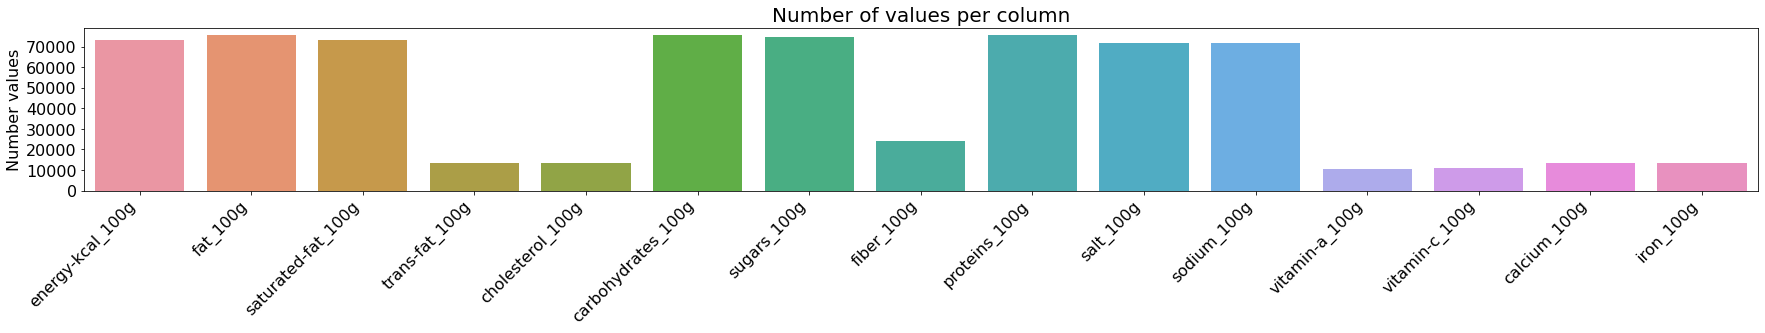

In [ ]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr.columns, y=nutr.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

#### 3.5.4.1 Original

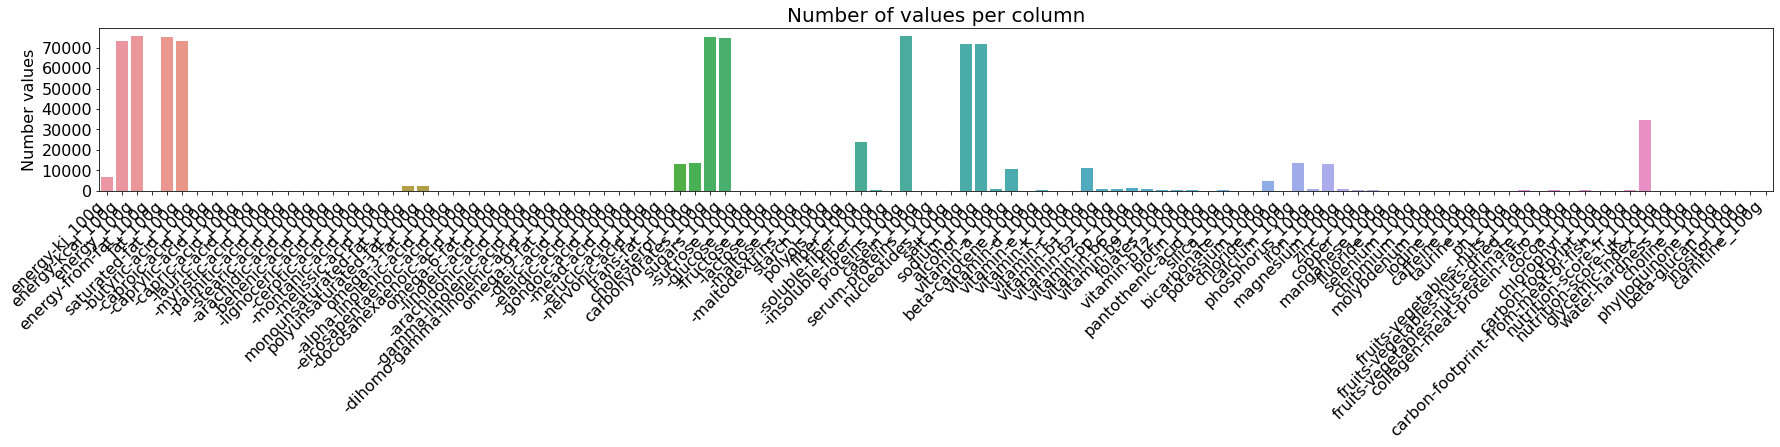

In [ ]:
plt.figure(figsize=(30,3))

barplot = sns.barplot(x=nutr_features, y=data[nutr_features].count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
## 3.6 Results

In [ ]:
general_infos.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name
86295,00380652,http://world-en.openfoodfacts.org/product/0038...,kiliweb,1582652492,2020-02-25T17:41:32Z,1587336818,2020-04-19T22:53:38Z,Hot & spcy goujons
328,0000000200349,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1525780476,2018-05-08T11:54:36Z,1561463838,2019-06-25T11:57:18Z,Mini muffins fourrés caramel 8+4GRT
16717,0011225124501,http://world-en.openfoodfacts.org/product/0011...,usda-ndb-import,1489078023,2017-03-09T16:47:03Z,1609135345,2020-12-28T06:02:25Z,Hazelnut Non-Dairy Coffee Creamer
46618,22314015020,http://world-en.openfoodfacts.org/product/0022...,kiliweb,1547133447,2019-01-10T15:17:27Z,1547133448,2019-01-10T15:17:28Z,Crême De Marrons De L'ardèche
47547,23087000305,http://world-en.openfoodfacts.org/product/0023...,usda-ndb-import,1489135327,2017-03-10T08:42:07Z,1587627195,2020-04-23T07:33:15Z,Jalapeno Peanut Brittle


In [ ]:
misc.head()

,serving_quantity,additives_n,additives_en,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,nutriscore_score,nutriscore_grade,nova_group,pnns_groups_1,pnns_groups_2,brand_owner,ecoscore_score_fr,ecoscore_grade_fr,main_category_en,image_url,image_small_url,image_ingredients_url,image_ingredients_small_url,image_nutrition_url,image_nutrition_small_url
86295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
328,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN
16717,15.0,6.0,"E340 - Potassium phosphates,E340ii - Dipotassi...",0.0,0.0,10.0,c,4.0,Beverages,Plant-based milk substitutes,WIDE AWAKE COFFEE CO.,NaN,NaN,Creamer,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...
46618,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,unknown,unknown,NaN,NaN,NaN,NaN,NaN,NaN,https://images.openfoodfacts.org/images/produc...,https://images.openfoodfacts.org/images/produc...,NaN,NaN
47547,57.0,6.0,"E160a - Carotene,E160ai - Beta-carotene,E211 -...",0.0,1.0,18.0,d,4.0,Sugary snacks,Sweets,Mrs. Annie's Peanut Brittle Co,NaN,NaN,Confectioneries,NaN,NaN,NaN,NaN,NaN,NaN


_____________________________________________________________________ END TESTS _________________________________________________________________________________

In [ ]:
features = general_infos.join([tags, ingredients, misc, nutr])

In [ ]:
features.shape

(95365, 58)

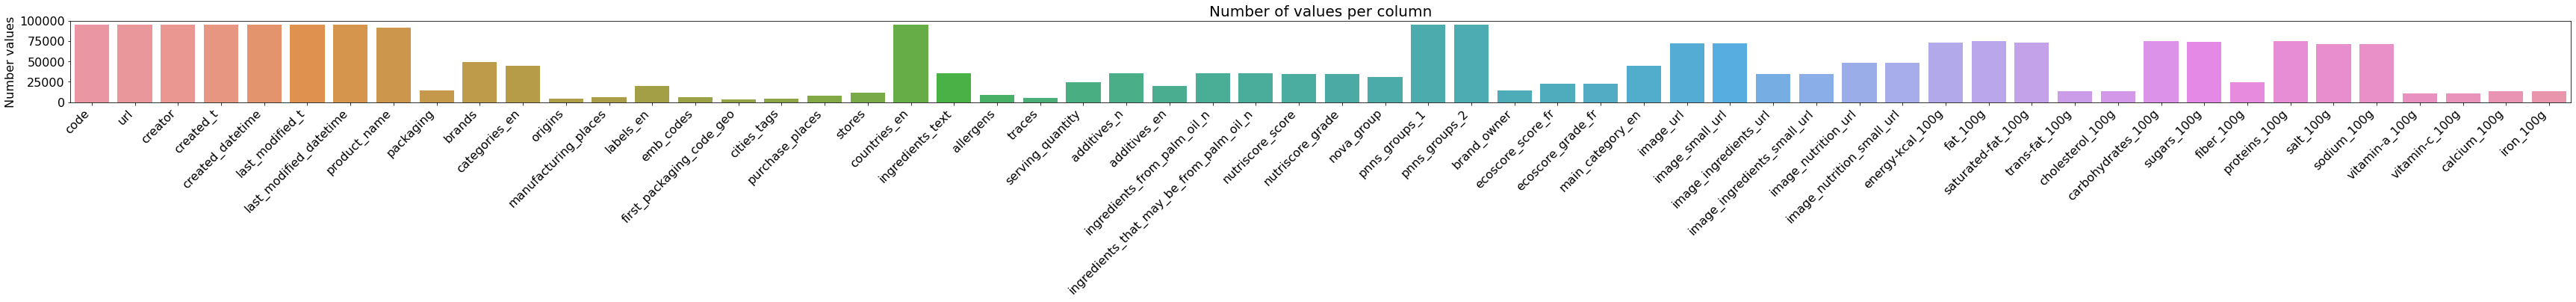

In [ ]:
plt.figure(figsize=(60,2))

barplot = sns.barplot(x=features.columns, y=features.count())

plt.title("Number of values per column", size=20)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.ylabel("Number values", size=16)
plt.show()

***
# 4 Saving

In [ ]:
features.shape

(95365, 58)

In [ ]:
features.to_csv("datas/sample.csv", sep=";")

***
# ? Nutriscore

## Nutriscore feature analysis

In [ ]:
nutriscore_features = [
    "fruits-vegetables-nuts_100g",
    "proteins_100g",
    "fiber_100g",
    "sugars_100g",
    "salt_100g",
    "saturated-fat_100g",
    "energy-kcal_100g"
]

In [ ]:
nutriscore_data = data.loc[:, ["nutriscore_score", "nutriscore_grade", "nutrition-score-fr_100g"]]
nutriscore_data.head(10)

,nutriscore_score,nutriscore_grade,nutrition-score-fr_100g
86295,NaN,NaN,NaN
328,NaN,NaN,NaN
16717,10.0,c,10.0
46618,NaN,NaN,NaN
47547,18.0,d,18.0
48409,5.0,c,5.0
67078,NaN,NaN,NaN
70100,5.0,c,5.0
40013,17.0,d,17.0
82134,NaN,NaN,NaN


In [ ]:
na = nutriscore_data.any(axis="columns")
print("at least one value: ", na.sum())
print("nutriscore_grade recorded: ", data.nutriscore_grade.notna().sum())
print("all rows: ", na.count())

at least one value:  34849
nutriscore_grade recorded:  34849
all rows:  95365


We can see that these threee features "nutriscore_score", "nutriscore_grade" and "nutrition-fr_100G" are redundant. Each time there is at least one of them recorded, the two others are also filled.

We can then get ride of "nutrition-fr_100g" and keep the two others.

In [ ]:
features += ["nutriscore_score", "nutriscore_grade"]

ValueError: Unable to coerce to Series, length must be 58: given 2

Too few entries have nutriscore cell filled, around 33%.
Could be a way to calculate it manually from other fields ?

## Nutriscore needed data

Is there a way to calculate Nutriscore from the others information ?

For that, we need to have the P and N ingredients of the nutriscore formula.

P (positive) ingredients:
- fruits, vegetable, nuts
- proteins
- fiber

N (negative) ingredients:
- sugar
- salt
- saturated fatty acid
- energy (kcal)

In [ ]:
p = [
    "fruit",
    "vegetable",
    "nuts",
    "olive",
    "fiber"
]

In [ ]:
n = [
    "sugar",
    "sodium",
    "saturated fatr"
]

## Search for needed fields/features

In [ ]:
results = []
for ingredient in p + n:
    for column in data.columns:
        if ingredient in column:
            results.append(column)
print(len(results))
results

## Nutriscore's features content analysis

They are the fields needed for the nutriscore formulas, but:
- "fruits-vegetables-nuts_100g": completely empty
- "fiber": too fews records, but could simply be due to the fact not all product contains fiber

## Where are the fruits, vegetables and nuts ?

In [ ]:
pd.set_option('display.max_colwidth', None)

ingredient_text_data = data[data.ingredients_text.notna()].ingredients_text
ingredient_text_data.head(5)

In [ ]:
def search(row, col: str, match: list):
    for m in match:
        if m in row[col]:
            print("row[col]: ", row[col])
            # return row[col].index

data[data.ingredients_text.notna()].iloc[:10].apply(lambda row: search(row, "ingredients_text", p), axis=1)

Even if we succed to demonstrate the concentration in fruits/evetables/nuts of certain products, we still can't calculate the nutriscore because we don't have the proportion of those elements per 100g.

### Conclusion
There is now way to calculate the nutriscore.